In [1]:
%matplotlib inline

In [2]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
import tensorflow.keras
import tensorflow as tf
from tensorflow.keras import optimizers
from sklearn.metrics import classification_report

In [3]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/MyDrive/COVID-CT-master/Images-processed/COVID-19_CT

/content/drive/MyDrive/COVID-CT-master/Images-processed/COVID-19_CT


# Data Import & Preprocessing

In [5]:
# 링크 다 더해서 train_test_split하기 
IMG_DIM = (224, 224,3)
COVID_files = glob.glob('COVID/*')
COVID_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in COVID_files]
COVID_labels = ["COVID" for _ in range(len(COVID_files))] 

NON_files = glob.glob('NONCOVID/*')
NON_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in NON_files]
NON_labels = ["NONCOVID" for _ in range(len(NON_files))] 

In [6]:
train = COVID_imgs + NON_imgs
train = np.array(train)

train_labels = COVID_labels + NON_labels

In [7]:
train_imgs, val_imgs, Y_train, Y_validation = train_test_split(train, train_labels, test_size=0.4, shuffle=True) #train : 60%, validation : 20% test : 20%
print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', val_imgs.shape)

validation_imgs, test_imgs, Y_val, Y_test = train_test_split(val_imgs, Y_validation, test_size=0.5, shuffle=True)
print('Validation dataset shape:', validation_imgs.shape, 
      '\tTest dataset shape:', test_imgs.shape)

Train dataset shape: (447, 224, 224, 3) 	Validation dataset shape: (299, 224, 224, 3)
Validation dataset shape: (149, 224, 224, 3) 	Test dataset shape: (150, 224, 224, 3)


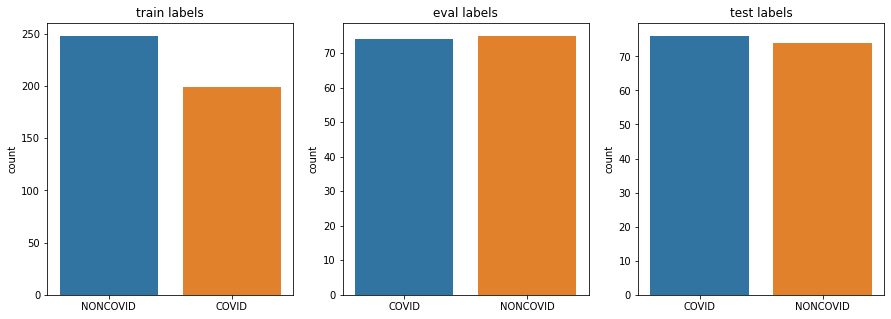

In [8]:
import seaborn as sns
plt.figure(1 , figsize = (15 ,5))
n = 0 
for z , j in zip([Y_train , Y_val, Y_test] , ['train labels','eval labels', 'test labels']):
    n += 1
    plt.subplot(1 , 3  , n)
    sns.countplot(x = z )
    plt.title(j)
plt.show()

In [9]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

In [10]:
le = LabelEncoder()
le.fit(train_labels)
# encode wine type labels
train_labels_enc = le.transform(Y_train)
validation_labels_enc = le.transform(Y_val)
test_labels_enc = le.transform(Y_test)

print(Y_train[0:5], Y_val[0:5])

['NONCOVID', 'NONCOVID', 'COVID', 'NONCOVID', 'NONCOVID'] ['COVID', 'COVID', 'COVID', 'COVID', 'NONCOVID']


In [11]:
batch_size = 30
epochs = 80
input_shape = (224, 224, 3)

# Modeling

In [12]:
vgg = vgg16.VGG16(include_top=False, weights='imagenet', #폐렴은 inception에서 가중치 가져오는 것이 좋음 -> inception은 흑백 데이터에서 train함/ imagenet은 컬러 데이터에서 train함
                                     input_shape=input_shape) #include_top: fc layer 가져올것인지

In [13]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
vgg.trainable = False #freeze

for layer in vgg.layers:
    layer.trainable = False

In [15]:
output = vgg.layers[-1].output 
output = tf.keras.layers.Flatten()(output) 
output = tf.keras.layers.Dense(512, activation='relu')(output)
output = tf.keras.layers.Dropout(0.3)(output)
output = tf.keras.layers.Dense(512, activation='relu')(output)
output = tf.keras.layers.Dropout(0.3)(output)
output = tf.keras.layers.Dense(1, activation='sigmoid')(output)
vgg_model = Model(vgg.input, output)

vgg_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['accuracy'])


vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [16]:
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) #keras에서 가지고 있는 layer의 타입

<ipython-input-16-2f0755cc5b61>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f659e219190>,input_1,False
1,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f659e219280>,block1_conv1,False
2,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f6607bb64f0>,block1_conv2,False
3,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f659e217fd0>,block1_pool,False
4,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f659de07370>,block2_conv1,False
5,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f659de078b0>,block2_conv2,False
6,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f659d96a430>,block2_pool,False
7,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f659d98ebe0>,block3_conv1,False
8,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f659d9257c0>,block3_conv2,False
9,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f659d925610>,block3_conv3,False


1/1 [==============================] - 5s 5s/step
(1, 7, 7, 512)


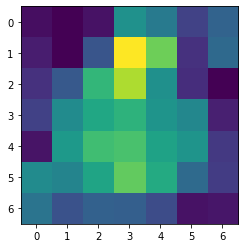

In [17]:
#맨 마지막의 특징맵
bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [18]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = vgg_model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(validation_imgs_scaled, validation_labels_enc), 
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[callback],
                    verbose=1)

Epoch 1/80
15/15 [==============================] - 12s 576ms/step - loss: 0.7438 - accuracy: 0.5034 - val_loss: 0.6687 - val_accuracy: 0.5168
Epoch 2/80
15/15 [==============================] - 3s 207ms/step - loss: 0.6453 - accuracy: 0.6286 - val_loss: 0.6094 - val_accuracy: 0.6711
Epoch 3/80
15/15 [==============================] - 3s 208ms/step - loss: 0.5774 - accuracy: 0.7069 - val_loss: 0.6031 - val_accuracy: 0.6510
Epoch 4/80
15/15 [==============================] - 3s 208ms/step - loss: 0.5454 - accuracy: 0.7271 - val_loss: 0.5943 - val_accuracy: 0.6443
Epoch 5/80
15/15 [==============================] - 3s 211ms/step - loss: 0.5197 - accuracy: 0.7539 - val_loss: 0.5752 - val_accuracy: 0.6779
Epoch 6/80
15/15 [==============================] - 3s 211ms/step - loss: 0.4791 - accuracy: 0.7808 - val_loss: 0.5389 - val_accuracy: 0.6913
Epoch 7/80
15/15 [==============================] - 3s 213ms/step - loss: 0.4548 - accuracy: 0.8031 - val_loss: 0.5471 - val_accuracy: 0.6846
Epoch

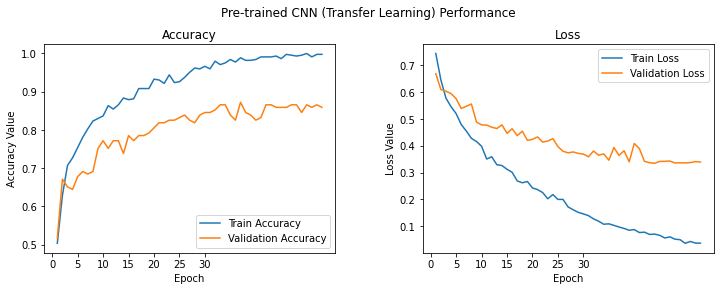

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,54))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")


In [21]:
from sklearn.metrics import confusion_matrix
yhat = vgg_model.predict(test_imgs_scaled)
y_pred=np.where(yhat>0.5,1,0)
y_pred = np.sum((y_pred), axis=1)
print(y_pred)

5/5 [==============================] - 6s 652ms/step
[0 0 1 1 0 0 1 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0
 1 0 1 1 0 0 0 1 1 1 0 0 0 1 0 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 1 0 1
 0 1 1 0 1 1 1 1 0 1 1 1 0 1 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0
 1 0 1 0 1 0 0 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 1 0 0 0 1 1 0 1 1 1 0 1 0 0 1
 1 1]


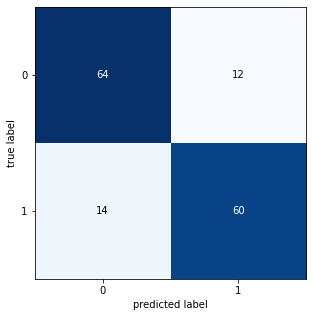

In [22]:
CM = confusion_matrix(test_labels_enc, y_pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [23]:
print(classification_report(test_labels_enc,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83        76
           1       0.83      0.81      0.82        74

    accuracy                           0.83       150
   macro avg       0.83      0.83      0.83       150
weighted avg       0.83      0.83      0.83       150



# XAI - Lime 적용

In [24]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

explainer = lime_image.LimeImageExplainer()

In [36]:
# 이미지를 슈퍼픽셀로 분할하는 알고리즘 설정
# quickshift, slic, felzenswalb 등이 존재
segmenter = SegmentationAlgorithm('slic',
                                   n_segments=100, # 이미지 분할 조각 개수
                                   compactnes=1, # 유사한 파트를 합치는 함수
                                   sigma=1) # 스무딩 역할: 0과 1사이의 float

In [44]:
exp = explainer.explain_instance(test_imgs_scaled[0],
                                classifier_fn=vgg_model.predict, #class 확률 반환
                                top_labels=2, # 확률 기준 1~5위
                                num_samples=1000, # sample space
                                segmentation_fn=segmenter) # 분할 알고리즘

/usr/local/lib/python3.8/dist-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Text(0.5, 1.0, 'Show mask only')

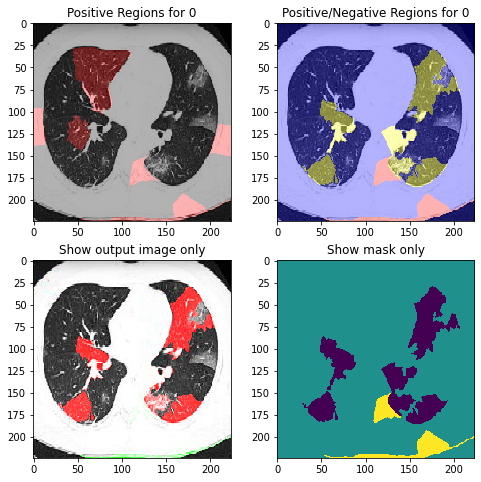

In [45]:
# sklearn의 regressor 기본 설명 모델로 사용
from skimage.color import label2rgb


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 8))
ax = [ax1, ax2, ax3, ax4]
for i in ax:
    i.grid(False)
# 예측에 가장 도움되는 세그먼트만 출력
temp, mask = exp.get_image_and_mask(test_labels_enc[0],
                                 positive_only=True, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                 num_features=8, # 분할 영역의 크기
                                 hide_rest=False) # 이미지를 분류하는 데 도움이 되는 서브모듈 외의 모듈도 출력
# label2rgb : 형광색 마스킹
ax1.imshow(label2rgb(mask, temp, bg_label=0), interpolation='nearest')
ax1.set_title('Positive Regions for {}'.format(test_labels_enc[0]))

# 모든 세그먼트 출력
temp, mask = exp.get_image_and_mask(test_labels_enc[0],
                                 positive_only=False, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                 num_features=8, # 분할 영역의 크기
                                 hide_rest=False) # 이미지를 분류하는 데 도움이 되는 서브모듈 외의 모듈도 출력

ax2.imshow(label2rgb(4-mask, temp, bg_label=0), interpolation='nearest') # 역변환
ax2.set_title('Positive/Negative Regions for {}'.format(test_labels_enc[0]))

# 이미지만 출력
ax3.imshow(temp, interpolation='nearest')
ax3.set_title('Show output image only')

# 마스크만 출력
ax4.imshow(mask, interpolation='nearest') # 정수형 array
ax4.set_title('Show mask only')